In [1]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

def load_nodeinfo_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT * FROM {tbl};'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [2]:
#calculate centrality
import math
import numpy as np

def entropynorm(values):
    vs = np.array(values)
    num = vs.size
    tt = np.sum(vs)
    vs = vs/tt

    npi = np.sum(vs*np.log2(vs, out=np.zeros_like(vs), where=(vs!=0)))
    dpi = math.log2(num)
    return - npi/dpi

def fairnessnorm(values):
    vs = np.array(values)
    num = vs.size

    npi = np.sum(vs)
    npi = npi**2
    dpi = np.square(vs).sum()
    dpi = dpi*num
    
    fn = (npi/dpi - 1/num) / (1 - 1/num)
    
    return fn

values_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0.17, 0.17, 0.13, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05, 0.03],
                [0.42, 0.2, 0.14, 0.07, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]
                ]

print(entropynorm(values_list[2]))
print(fairnessnorm(values_list[1]))

0.7556018366014379
0.8056472313898059


In [3]:
import os

#PATH = "../blockchainnode/db_nodes"
# PATH = "../PoS_20221130_083413"
PATH = "../PoS_Starks_20230405_082545"

fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
if len(fdbs) == 0:
    subdirs = [x[0] for x in os.walk(PATH)]
    for subd in subdirs:
        subbs = [os.path.join(subd, f) for f in os.listdir(subd) if f.split(".")[-1] == 'db']
        fdbs.extend(subbs)

fdbs.sort()
print(fdbs)

['../PoS_Starks_20230405_082545/node0.local/7031.db', '../PoS_Starks_20230405_082545/node1.local/7032.db', '../PoS_Starks_20230405_082545/node2.local/7033.db', '../PoS_Starks_20230405_082545/node3.local/7034.db', '../PoS_Starks_20230405_082545/node4.local/7035.db', '../PoS_Starks_20230405_082545/node5.local/7036.db', '../PoS_Starks_20230405_082545/node6.local/7037.db', '../PoS_Starks_20230405_082545/node7.local/7038.db']


[49, 39, 49, 33, 47, 43, 52, 54] 366
[317, 326, 311, 332, 313, 320, 314, 309] 2542
Fairness Proof 0.9768954275683358
Entropy Proof 0.9948333630901723


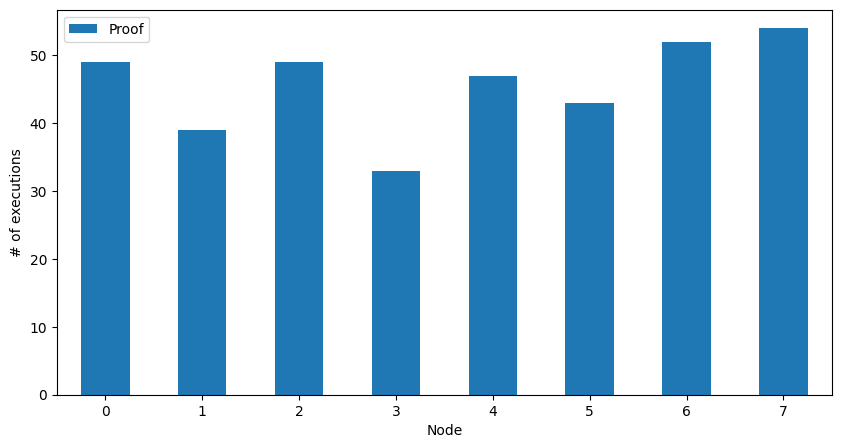

In [4]:
# Count chart for proof and verify
from matplotlib import pyplot as plt
    
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof, sum(proof))

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif, sum(verif))

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("# of executions")
plt.savefig('Num_Prover_Verifier.png', dpi=300, bbox_inches='tight')

print('Fairness Proof', fairnessnorm(proof))
# print('Fairness Verification', fairnessnorm(verif))

print('Entropy Proof', entropynorm(proof))
# print('Entropy Verification', entropynorm(verif))




Avg Proof[msec] 4496.198185311721
Avg Verif[msec] 745.9835911569623


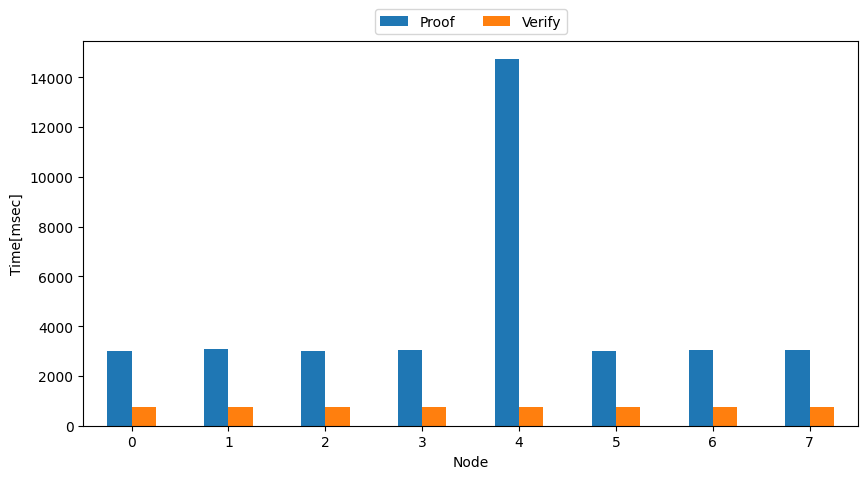

In [5]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
# print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
# verifrev = []
for i, df in enumerate(dfs):
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    # verifrev.append(df['timeverifrev'].mean()/unit)
# print(veriffwd)
# print(verifrev)

ch_list = [proof, veriffwd]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Time[msec]")
# plt.legend(loc='right')
# ax.set_yscale('log')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=5)

plt.savefig('Avg_Time_Proof_Verify.png', dpi=300, bbox_inches='tight')

print('Avg Proof[msec]', sum(proof)/len(proof))
print('Avg Verif[msec]', sum(veriffwd)/len(veriffwd))
# print('Avg Verif Back[msec]', sum(verifrev)/len(verifrev))


Avg size of verification Time T1    2.727557
T2    6.230416
T3    8.957973
dtype: float64


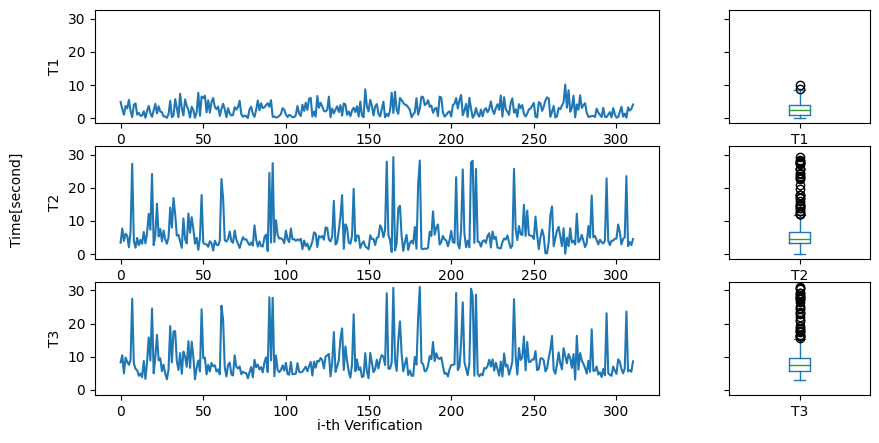

In [6]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000000000 #sec
dfs = load_data_from_db(fdbs, 'veriftbl')
timelastblock = []
timercvlastblock = []
timercvpos = []
for i, df in enumerate(dfs):
    timelastblock.append(df['timelastblock'])
    timercvlastblock.append(df['timercvlastblock'])
    timercvpos.append(df['timercvpos'])
node = 2
ch_list = [timelastblock[node], timercvlastblock[node], timercvpos[node]]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Last Block', 'Receive Block', 'Receive PoS']

tdf = pd.DataFrame()
tdf['T1'] = (bdf['Receive Block'] - bdf['Last Block'])/unit
tdf['T2'] = (bdf['Receive PoS'] - bdf['Receive Block'])/unit
tdf['T3'] = (bdf['Receive PoS'] - bdf['Last Block'])/unit

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
fig.text(0.04, 0.5, 'Time[second]', va='center', rotation='vertical')
fig.text(0.4, 0.04, 'i-th Verification', ha='center')

tdf['T1'].plot.line(ax=axes[0][0], ylabel='T1')
tdf['T1'].plot.box(ax=axes[0][1])
tdf['T2'].plot.line(ax=axes[1][0], ylabel='T2')
tdf['T2'].plot.box(ax=axes[1][1])
tdf['T3'].plot.line(ax=axes[2][0], ylabel='T3')
tdf['T3'].plot.box(ax=axes[2][1])

# plt.xlabel("Iteration")
# plt.ylabel("Time")
plt.savefig(f'Verifcation_Time_Node{node}.png', dpi=300, bbox_inches='tight')

print('Avg size of verification Time', tdf.mean())


[311.4232244897959, 311.1360512820513, 311.79214285714284, 309.3332727272727, 309.82908510638293, 312.0741860465116, 311.7715576923077, 312.8327777777778]
Avg size of proof 311.2740372474054


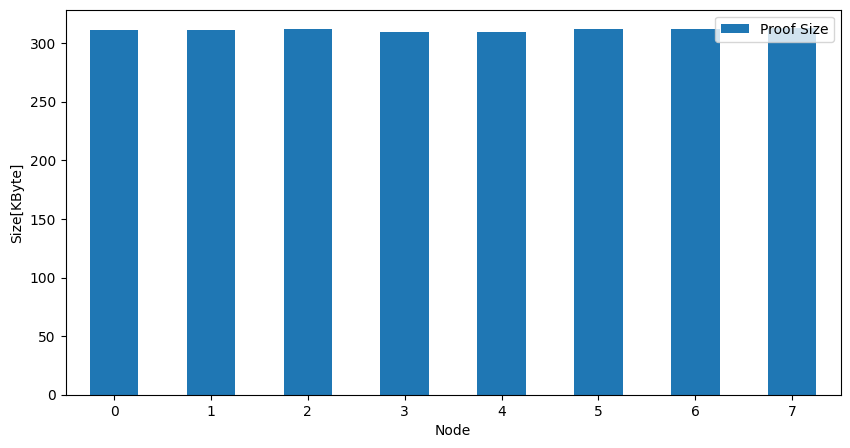

In [7]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['sizegenproof'].mean()/unit)
print(proof)

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof Size']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Size[KByte]")
plt.savefig('Avg_Size_Proof.png', dpi=300, bbox_inches='tight')

print('Avg size of proof', sum(proof)/len(proof))

In [13]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def get_nodes():
    dfs = load_nodeinfo_from_db(fdbs, 'nodeinfo')
    nodes = []
    for df in dfs:
        nodes.append(df['hash'].values[-1])
    return nodes

def get_dhn_nodes(issum=True):
    unit = 1000000000 #sec
    C = 10.
    # Vt = 1.
    # Wt = 13.
    dfs = load_data_from_db(fdbs, 'veriftbl')
    UPPER = 500
    nodes = get_nodes()
    for n in nodes:
        print(n)

    df_dhn = {}
    for df in dfs:
        def get_dhn_sum():
            df2 = df.groupby('nodeaddress', sort=True)['Dhn'].sum().reset_index(name ='Dhn')
            for k, n in enumerate(nodes):
                if False == df2['nodeaddress'].isin([n]).any():
                    df2.loc[len(df2)] = [n, 0]
                    idx = k
                    
            df2 = df2.sort_values(by=['nodeaddress'])
            df2 = df2.reset_index()
            return idx, df2
        
        def get_dhn_time_event():
            for k, n in enumerate(nodes):
                if False == df['nodeaddress'].isin([n]).any():
                    idx = k
            data = {}
            for k, n in enumerate(nodes):
                if k != idx:
                    data[n] = [0]
            
            df2=pd.DataFrame(data)
            for k, row in df.iterrows():
                df2.loc[len(df2)] = [row['Dhn'] if row['nodeaddress'] == n else 0 for n in df2.columns]
            return idx, df2
        
        idx = 0
        df['td'] = (df['timercvpos'] - df['timercvlastblock'])/unit
        df['wt0'] = (df['timercvlastblock'] - df['timelastblock'])/unit
        df['wt'] = df['wt0'].expanding().mean()+(13.56-2.45)*0.7
        # print(df['wt'].tail(20))s

        # df['awt'] = df['wt'].expanding().mean()
        # print(df['awt'].tail(20))
        # df['Dhn_0'] = C*(1 - (df['timercvpos'] - df['timercvlastblock'])/unit/Wt)
        df['Dhn_0'] = C*(1 - (df['td'])/df['wt'])
        df['Dhn'] = np.exp(df['Dhn_0'])
        df['Dhn'].clip(upper=UPPER, inplace=True)
        # print(df['Dhn'].tail(20))
        
        idx, df2 = get_dhn_sum() if issum == True  else get_dhn_time_event()

        # print(df2)
        df_dhn[idx] = df2
    return nodes, df_dhn


48734f0b709f4e4b116fa8c1a92261caa372e4c5adca14ddee9862ab95dcf556
0e2e0bba42e32840093d7e8c2b9c9236fde567438d7860ee06f3895a45195624
2e9470daad39eade070d611ce26026b83d7d265c357f651e681a28e623737e4c
b97231ffdfce1a15113dad7ce81c5e891188338a73d36486e456d2e0f7d21e85
b1e378b1bfe55703bb9bc4a03f2c0841cd6182fb64cda40ab447a6ece5aafce5
4a953fb2157145ad0c7c6fb1d56be1beaddc16d638b620283054ac8db0576c9f
c6cc5a2c9c13d8f473e829647153562a38edfa995e530108f5c52e3002b715db
c9eef5297ce5012419061bc896dc6a3caa928ed6fe8026262cf93404a027f82e


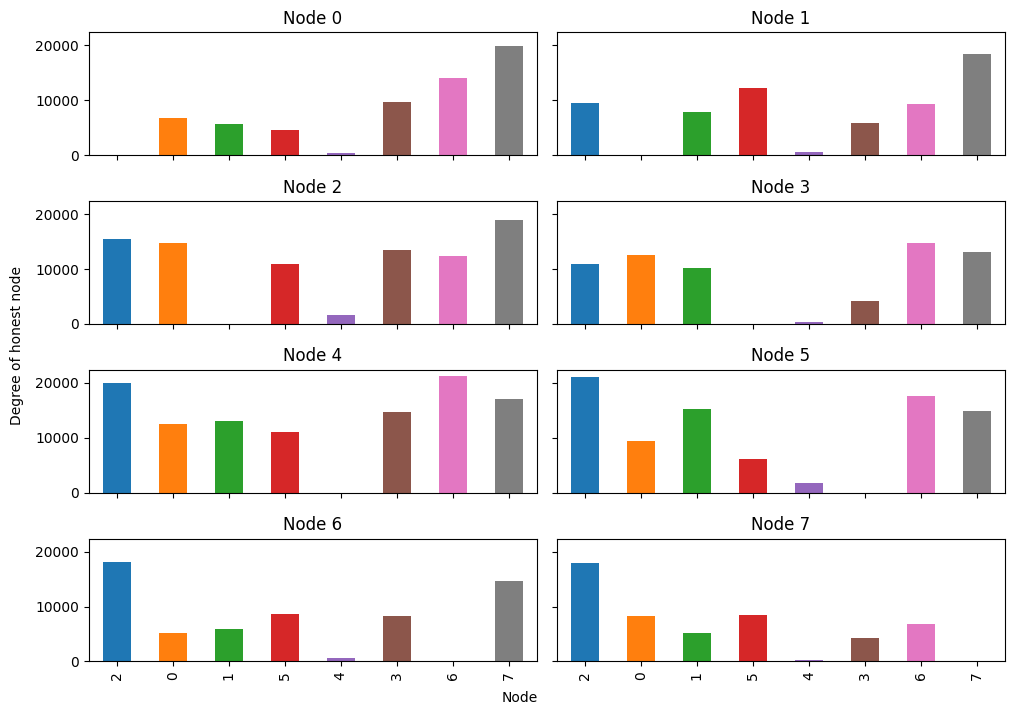

In [33]:
nodes, dfs = get_dhn_nodes()

colormap = {}
colors = mcolors.TABLEAU_COLORS
for i, (n, k) in enumerate(zip(nodes, colors.keys())):
    colormap[n] = colors[k]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 7), sharey=True, sharex=True, constrained_layout=False)
fig.text(-0.01, 0.5, 'Degree of honest node', va='center', rotation='vertical')
fig.text(0.5, -0.01, 'Node', ha='center')

for idx, df in dfs.items():
    df = df.sort_values(by='nodeaddress', key=lambda column: column.map(lambda e: nodes.index(e)))
    if idx%2 == 0:
        ax = axes[idx//2][0]
        df['Dhn'].plot(ax=ax, kind='bar',  color=df['nodeaddress'].replace(colormap))
        ax.set_title(f'Node {idx}')
    else:
        ax = axes[idx//2][1]
        df['Dhn'].plot(ax=ax, kind='bar',  color=df['nodeaddress'].replace(colormap))
        ax.set_title(f'Node {idx}')

fig.tight_layout() 
plt.savefig('DegreeHonestProver.png', dpi=300, bbox_inches='tight')
plt.show()


48734f0b709f4e4b116fa8c1a92261caa372e4c5adca14ddee9862ab95dcf556
0e2e0bba42e32840093d7e8c2b9c9236fde567438d7860ee06f3895a45195624
2e9470daad39eade070d611ce26026b83d7d265c357f651e681a28e623737e4c
b97231ffdfce1a15113dad7ce81c5e891188338a73d36486e456d2e0f7d21e85
b1e378b1bfe55703bb9bc4a03f2c0841cd6182fb64cda40ab447a6ece5aafce5
4a953fb2157145ad0c7c6fb1d56be1beaddc16d638b620283054ac8db0576c9f
c6cc5a2c9c13d8f473e829647153562a38edfa995e530108f5c52e3002b715db
c9eef5297ce5012419061bc896dc6a3caa928ed6fe8026262cf93404a027f82e
297    9.221465
298    9.217078
299    9.213062
300    9.210613
301    9.208101
302    9.205518
303    9.201999
304    9.204272
305    9.201813
306    9.197751
307    9.203982
308    9.203878
309    9.210575
310    9.207005
311    9.203839
312    9.200082
313    9.197763
314    9.198320
315    9.194559
316    9.195903
Name: wt, dtype: float64
306    9.763136
307    9.757205
308    9.752113
309    9.749639
310    9.745060
311    9.744143
312    9.742473
313    9.743253
314    

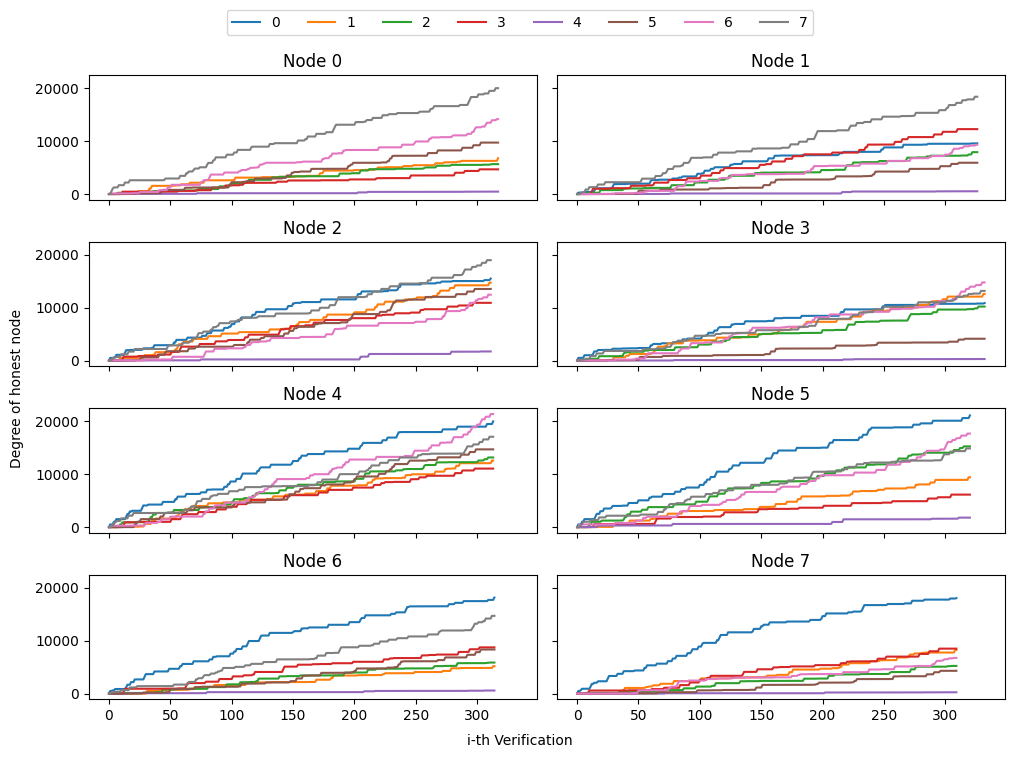

In [10]:
nodes, dfs = get_dhn_nodes(issum=False)

colormap = {}
colors = mcolors.TABLEAU_COLORS
for i, (n, k) in enumerate(zip(nodes, colors.keys())):
    colormap[n] = colors[k]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 7), sharey=True, sharex=True, constrained_layout=False)
fig.text(-0.01, 0.5, 'Degree of honest node', va='center', rotation='vertical')
fig.text(0.5, -0.01, 'i-th Verification', ha='center')
labels = [i for i in range(len(nodes))]

dummy = {}
for n in nodes:
    dummy[n] = [0]
dummy_df = pd.DataFrame(dummy)
dummy_df.cumsum().plot(ax=axes[0][0], kind='line', legend=None, color=colormap)

for idx, df in dfs.items(): 
    if idx%2 == 0:
        ax = axes[idx//2][0]
        df.cumsum().plot(ax=ax, kind='line', legend=None, color=colormap)
        ax.set_title(f'Node {idx}')
    else:
        ax = axes[idx//2][1]
        df.cumsum().plot(ax=ax, kind='line', legend=None, color=colormap)
        ax.set_title(f'Node {idx}')

fig.tight_layout() 
fig.legend(labels, loc='upper center', ncol=len(labels), bbox_transform=fig.transFigure, bbox_to_anchor=(0.5, 1.05))

plt.savefig('DegreeHonestProverTime.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
import numpy as np
 
def cal_evenness1(vdf, vmax):
    vdf['weight'] = (vmax - vdf['Height'])
    vdf['norm_cnt1'] = vdf['Count']/vdf['weight']
    values = vdf['norm_cnt1'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    
def cal_evenness2(vdf, vmax):
    vdf['norm_cnt2'] = vdf['Count']*vdf['Height']
    values = vdf['norm_cnt2'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)

def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(max(i, 5), vmax):
            pi += 1/(j-1)
        # pi = pi*np.log10(pi)
        pis.append(pi)
    
    # mpis = max(pis)
    mpis = sum(pis)
    # https://en.wikipedia.org/wiki/Entropy_(information_theory)
    pis2 = [x /mpis for x in pis]
    pis3 = [-np.log2(x) for x in pis2] 
    # print(pis2)
    plt.plot(pis2)
    return pis2, pis3

def cal_evenness3(vdf, vmax):
    # vdf = sdf.copy()
    pis, pis2 = cal_acc_prob(vmax)

    # vdf.set_index('Height', inplace=True)
    # vdf = vdf.reindex(list(range(0,vmax)),fill_value=0)    
    # vdf['weight'] =  pis
    # vdf['weight3'] = [pis2[v] for v in vdf['Height'].values]
    vdf['weight3'] = [1/pis[v] for v in vdf['Height'].values]
    # print('weights',vdf)
    vdf['norm_cnt3'] = vdf['Count']*vdf['weight3']
    # vdf['norm_cnt'] = vdf['Count2']*vdf['weight']

    # plt.plot(vdf['weight3'])

    # values = vdf['Count'].to_list()
    # vs = np.array(values)
    # num = vs.size
    # tt = np.sum(vs)
    # vs = vs/tt
    # # print('p(x)', vs)

    # ci_values =  vdf['weight3'].to_list()
    # ci = np.array(ci_values)
    # # print('CI=====', ci)

    # se = vs*ci
    # npi = np.sum(vs*ci)
    # dpi = math.log2(num)
    # print('Entropy', npi/dpi)
    # plt.plot(vs, 'g')
    # # plt.plot(ci, 'r')
    # plt.plot(se, 'b')

    values = vdf['norm_cnt3'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    # print(values)
    # plt.plot(values)
    
    # print(vdf['norm_cnt'])
    
    # vdf['norm_cnt'].plot()
cal_evenness1(bdf2, 720)
cal_evenness2(bdf2, 720)
cal_evenness3(bdf2, 720)

# print(bdf2)
# plt.plot(bdf2['norm_cnt1']*50, 'r')
# plt.plot(bdf2['norm_cnt2']/1284, 'b')
# plt.plot(bdf2['norm_cnt3']/20, 'g')



NameError: name 'bdf2' is not defined

In [ ]:
def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(i, vmax):
            pi += 1/(j+1)
        pis.append(pi*np.log10(i+1))
    # print(pis)
    
    return pis
pis = cal_acc_prob(720)
# plt.plot(pis)
bdf = pd.DataFrame([pis]).transpose()
bdf.columns = ['Count']
# ax = bdf.plot.hist(bins=12, label='Count')
bdf2

,Height,Count,weight,norm_cnt1,norm_cnt2,weight3,norm_cnt3
0,1,3,719,0.004172,3,136.372023,409.116069
1,2,3,718,0.004178,6,136.372023,409.116069
2,3,5,717,0.006974,15,136.372023,681.860115
3,4,2,716,0.002793,8,136.372023,272.744046
4,5,2,715,0.002797,10,136.372023,272.744046
...,...,...,...,...,...,...,...
215,628,2,92,0.021739,1256,5296.004112,10592.008224
216,639,1,81,0.012346,639,6066.663008,6066.663008
217,642,1,78,0.012821,642,6314.512680,6314.512680
218,650,1,70,0.014286,650,7079.180691,7079.180691
